In [1]:
# import and initialize
from pymcmcstat.MCMC  import MCMC 
import pandas as pd
import numpy as np
import mph
import scipy.io as sio
import matplotlib.pyplot as plt


In [2]:
data = sio.loadmat("../Data/laser/references/scanFlatBeamCornerMiddleLimit.mat")
ref = sio.loadmat("../Data/laser/references/FlatBeamRefCenter.mat")

tf_center = data["y_FRF_vel"][1] / ref["y_FRF_vel"][0]
tf_corner = data["y_FRF_vel"][0] / ref["y_FRF_vel"][0]

tf_center = tf_center
tf_corner = tf_corner

tf_center_dB = 20*np.log10(abs(tf_center))
tf_corner_dB = 20*np.log10(abs(tf_corner))
freq = data["x_FRF_vel"][1].T
freq = freq

In [3]:
print(len(freq))
print(np.shape(tf_center_dB))

12701
(12701,)


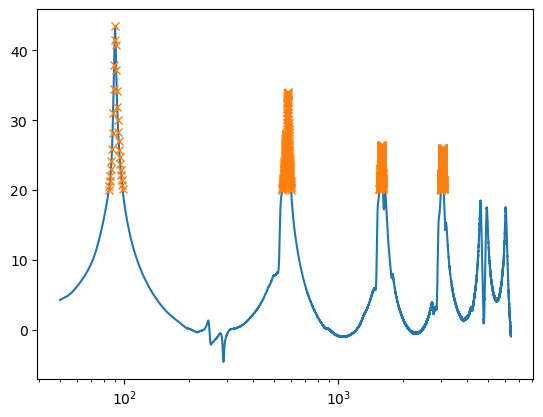

In [4]:
plt.plot(freq, tf_center_dB)

goalFreq = freq[tf_center_dB>20]
tf_goal = tf_center_dB[tf_center_dB>20]
plt.plot(goalFreq, tf_goal, "x")
plt.xscale("log")

In [5]:

client = mph.start()
#modelComsol = client.load("../comsol/beamSimpleTest1.mph")
modelComsol = client.load("../comsol/TestComsolPLA.mph")
goalFreq = freq[tf_center_dB>20]

def solveComsol(modelComsol, param):#, freq=10):
    
    # Update parameters
    E, rho, eta = param
    rho, eta, E = normalization(rho, eta, E)
    modelComsol.parameter('youngs', str(E)+' [Pa]')
    modelComsol.parameter('density', str(rho)+' [kg/m^3]')
    modelComsol.parameter('eta', str(eta))


    # Solving comsol FEM
    modelComsol.solve("Study 2")
    #comsolResults1 = torch.tensor(modelComsol.evaluate("comp1.point2"))
    meas = modelComsol.evaluate("comp1.point2")
    ref = modelComsol.evaluate("comp1.point1")
    comsolResults = meas/ref
    return abs(comsolResults)

def normalization(rho, eta, E):
    E_theo=2.5e9
    E_var_init =8e8
    rho_theo=1.24e3
    rho_var_init =224.0
    eta_mean=0.005
    eta_var_init = 0.01
    
    rho_norm = rho*rho_var_init + rho_theo
    eta_norm = eta*eta_var_init + eta_mean
    E_norm = E*E_var_init + E_theo

    return rho_norm, eta_norm, E_norm
    
def mobilityFuncModel(param):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    global goalFreq
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12
    param
    E, rho, eta = param
    rho, eta, E = normalization(rho, eta, E)
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*np.pi*goalFreq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = np.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
    D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*np.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)

[0.012s][warning][os,thread] Attempt to protect stack guard pages failed (0x000000016b364000-0x000000016b370000).
[0.012s][warning][os,thread] Attempt to deallocate stack guard pages failed.


In [ ]:
goalFreq

array([  84.5,   85. ,   85.5,   86. ,   86.5,   87. ,   87.5,   88. ,
         88.5,   89. ,   89.5,   90. ,   90.5,   91. ,   91.5,   92. ,
         92.5,   93. ,   93.5,   94. ,   94.5,   95. ,   95.5,   96. ,
         96.5,   97. ,   97.5,   98. ,  546.5,  547. ,  547.5,  548. ,
        548.5,  549. ,  549.5,  550. ,  550.5,  551. ,  551.5,  552. ,
        552.5,  553. ,  553.5,  554. ,  554.5,  555. ,  555.5,  556. ,
        556.5,  557. ,  557.5,  558. ,  558.5,  559. ,  559.5,  560. ,
        560.5,  561. ,  561.5,  562. ,  562.5,  563. ,  563.5,  564. ,
        564.5,  565. ,  565.5,  566. ,  566.5,  567. ,  567.5,  568. ,
        568.5,  569. ,  569.5,  570. ,  570.5,  571. ,  571.5,  572. ,
        572.5,  573. ,  573.5,  574. ,  574.5,  575. ,  575.5,  576. ,
        576.5,  577. ,  577.5,  578. ,  578.5,  579. ,  579.5,  580. ,
        580.5,  581. ,  581.5,  582. ,  582.5,  583. ,  583.5,  584. ,
        584.5,  585. ,  585.5,  586. ,  586.5,  587. ,  587.5,  588. ,
      

In [6]:
error = []
# Define sum of squares function
def ssfun(q, data):
    global error
    y = data.ydata[0].T
    y = y[0]
    # Evaluate model
    ymodel = solveComsol(modelComsol, q)
    res = ymodel - y
    error = np.append(error, (res ** 2).sum(axis=0))
    return (res ** 2).sum(axis=0)
# Define model settings
mcstat = MCMC()
mcstat.data.add_data_set(goalFreq, tf_goal)
mcstat.model_settings.define_model_settings(
    sos_function=ssfun)
# Define simulation options
mcstat.simulation_options.define_simulation_options( nsimu=1.5e3) # No. of MCMC simulations
# Add model parameters
mcstat.parameters.add_model_parameter(
    name='E',
    theta0=0., # initial value 
    minimum=-1.5, # lower limit 
    maximum=3)
mcstat.parameters.add_model_parameter(
    name='rho',
    theta0=0., # initial value 
    minimum=-1.5, # lower limit 
    maximum=1.5) # upper limit
mcstat.parameters.add_model_parameter(
    name='eta',
    theta0=0., # initial value 
    minimum=-1.5, # lower limit 
    maximum=3)
# Run simulation
mcstat.run_simulation()




Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         E:  0.00e+00 [    -1.50,      3.00] N( 0.00e+00,      inf)
       rho:  0.00e+00 [    -1.50,      1.50] N( 0.00e+00,      inf)
       eta:  0.00e+00 [    -1.50,      3.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1501 of 1500 complete in 13996.1 sec

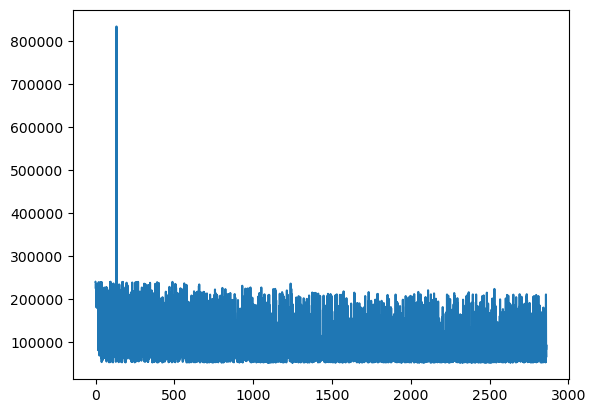

In [7]:
plt.plot(error)

/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_44082/3091468232.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) plot_chain_panel. (New function:"from pymcmcstat.mcmcplot import plot_chain_panel") -- Deprecated since version 1.9.0.
  mcpl.plot_chain_panel(chain[:10], names[:10])


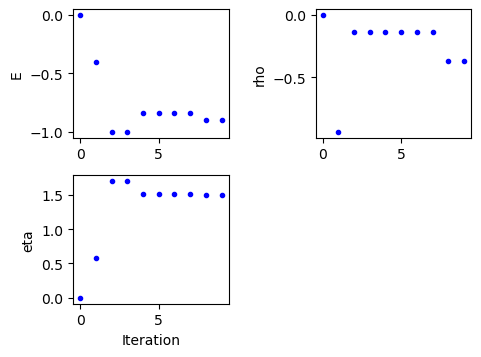

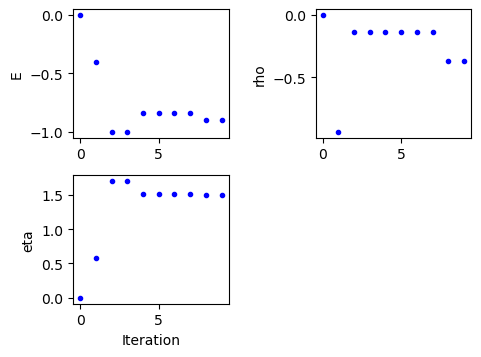

In [24]:
results = mcstat.simulation_results.results
chain = results['chain'] 
names = results['names']
# generate mcmc plots
mcpl = mcstat.mcmcplot # initialize plotting methods
mcpl.plot_chain_panel(chain[:10], names[:10])

In [ ]:
mcstat.simulation_results.results

{'theta': array([-0.74934686,  0.74881965, -0.68738518]),
 'parind': array([0, 1, 2]),
 'local': array([0., 0., 0.]),
 'total_rejected': 0.9562,
 'rejected_outside_bounds': 0.5892000000000001,
 'R': array([[ 0.05771074, -0.01912097,  0.04285235],
        [ 0.        ,  0.02118431, -0.07020351],
        [ 0.        ,  0.        ,  0.39709765]]),
 'qcov': array([[ 0.00333053, -0.00110349,  0.00247304],
        [-0.00110349,  0.00081439, -0.00230659],
        [ 0.00247304, -0.00230659,  0.1644514 ]]),
 'cov': array([[ 0.00173465, -0.00057473,  0.00128804],
        [-0.00057473,  0.00042416, -0.00120135],
        [ 0.00128804, -0.00120135,  0.08565177]]),
 'qcov_scale': 1.385640646055102,
 'mean': array([-0.74337256,  0.7454048 , -0.41720302]),
 'names': ['E', 'rho', 'eta'],
 'allnames': ['E', 'rho', 'eta'],
 'limits': [array([-0.75, -0.75, -0.75]), array([0.75, 0.75, 0.75])],
 'nsimu': 5000,
 'simutime': 16489.113869667053,
 'qcovorig': array([[ 0.00333053, -0.00110349,  0.00247304],
    

In [10]:
print(results['chain'])

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 ...
 [-1.34911876 -1.26284116  1.49388604]
 [-1.34911876 -1.26284116  1.49388604]
 [-1.34911876 -1.26284116  1.49388604]]


In [9]:

results = mcstat.simulation_results.results 
chain = results['chain'].copy()
burnin = int(chain.shape[0]/2)
# display chain statistics 
mcstat.chainstats(chain[burnin:, :], results)



------------------------------
      name:      mean       std    MC_err       tau    geweke
         E:      1.53      0.01  2.47e-03     89.87      0.98
       rho:     -1.17      0.01  2.51e-03     90.06      0.97
       eta:      1.47  5.72e-03  1.20e-03     77.14      1.00
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 0.27%
Stage 2: 0.87%
Net    : 1.13% -> 17/1500
---------------
Chain provided:
Net    : 0.53% -> 4/750
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_44082/2046878478.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) plot_density_panel. (New function: "from pymcmcstat.mcmcplot import plot_density_panel") -- Deprecated since version 1.9.0.
  mcpl.plot_density_panel(chain, names)


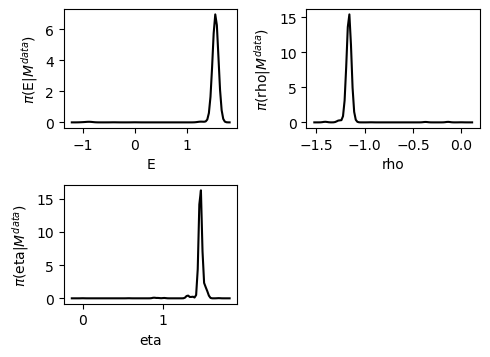

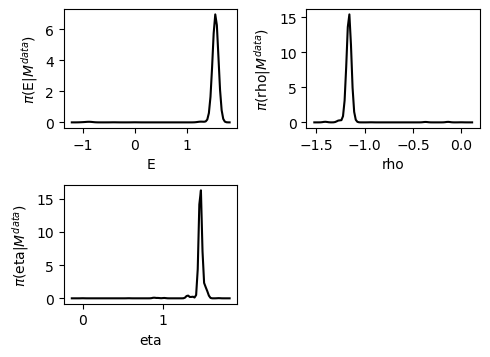

In [10]:
mcpl.plot_density_panel(chain, names)

/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_44082/1684520163.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) plot_pairwise_correlation_panel. (New function: "from pymcmcstat.mcmcplot import plot_pairwise_correlation_panel") -- Deprecated since version 1.9.0.
  mcpl.plot_pairwise_correlation_panel(chain[burnin:,:], names)


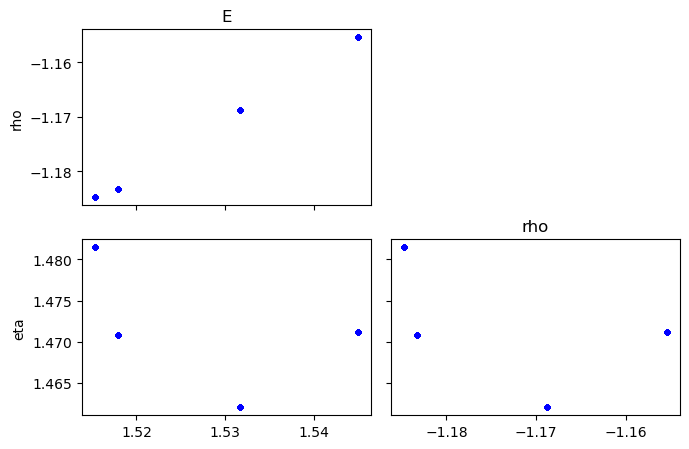

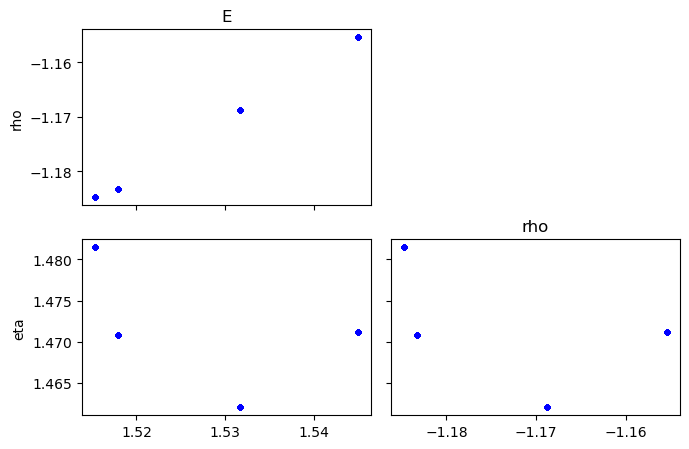

In [25]:
mcpl.plot_pairwise_correlation_panel(chain[burnin:,:], names)

In [22]:
chain[:,1], chain[:,2], chain[:,0] = normalization(chain[:,1], chain[:,2], chain[:,0])

/var/folders/pl/w3zkxkl91fl0j08xrh5r78hh0000gn/T/ipykernel_44082/2046878478.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) plot_density_panel. (New function: "from pymcmcstat.mcmcplot import plot_density_panel") -- Deprecated since version 1.9.0.
  mcpl.plot_density_panel(chain, names)


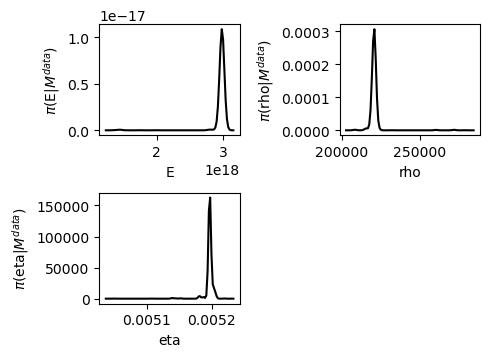

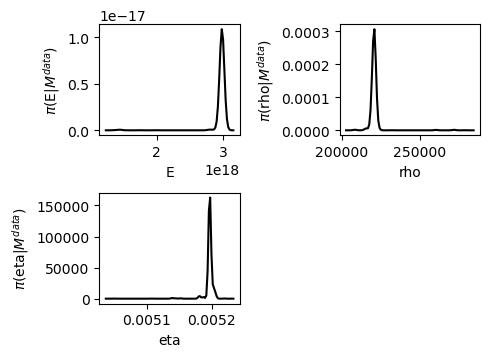

In [23]:
mcpl.plot_density_panel(chain, names)

In [14]:
from scipy import stats
mode_E = stats.mode(chain[:,0], keepdims=True)[0]
mode_rho = stats.mode(chain[:,1], keepdims=True)[0]
mode_eta = stats.mode(chain[:,2], keepdims=True)[0]
print(mode_E, mode_rho, mode_eta)

[3.73596948e+09] [981.18510748] [0.01971126]


In [16]:

def solveComsol(modelComsol, param):#, freq=10):
    
    # Update parameters
    E, rho, eta = param
    modelComsol.parameter('youngs', str(E)+' [Pa]')
    modelComsol.parameter('density', str(rho)+' [kg/m^3]')
    modelComsol.parameter('eta', str(eta))


    # Solving comsol FEM
    modelComsol.solve("Study 2")
    #comsolResults1 = torch.tensor(modelComsol.evaluate("comp1.point2"))
    meas = modelComsol.evaluate("comp1.point2")
    ref = modelComsol.evaluate("comp1.point1")
    return meas, ref

In [17]:

client = mph.start()
#modelComsol = client.load("../comsol/beamSimpleTest1.mph")
modelComsol = client.load("../comsol/TestComsolPLA.mph")
meas, ref =solveComsol(modelComsol, [3.73596948e+09, 981.18510748, 0.01971126])

In [18]:
results = {"vel_est": meas/ref,
           "E_est": 3.47582687e+09,  
           "E_dist": chain[:, 0],
           "rho_est": 1332.87040193,  
           "rho_dist": chain[:, 1],
           "eta_est": 0.20146556,
           "eta_dist": chain[:, 2],
           "completedResults": mcstat.simulation_results.results,
           "error": error,
           "time": 642}

In [19]:
import pickle
with open('../resultsLast/resultsFlatmoreVarNoLowFreqLastTestHigh.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Load data (deserialize)
"""
with open('filename.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
"""

"\nwith open('filename.pickle', 'rb') as handle:\n    unserialized_data = pickle.load(handle)\n"

In [20]:
data = sio.loadmat("../Data/laser/references/scanFlatBeamCornerMiddleLimit.mat")
ref = sio.loadmat("../Data/laser/references/FlatBeamRefCenter.mat")

tf_center = data["y_FRF_vel"][1] / ref["y_FRF_vel"][0]
tf_corner = data["y_FRF_vel"][0] / ref["y_FRF_vel"][0]
tf_center_dB = 20*np.log10(abs(tf_center))
tf_corner_dB = 20*np.log10(abs(tf_corner))
freq = data["x_FRF_vel"][1].T

/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(50, 4000)

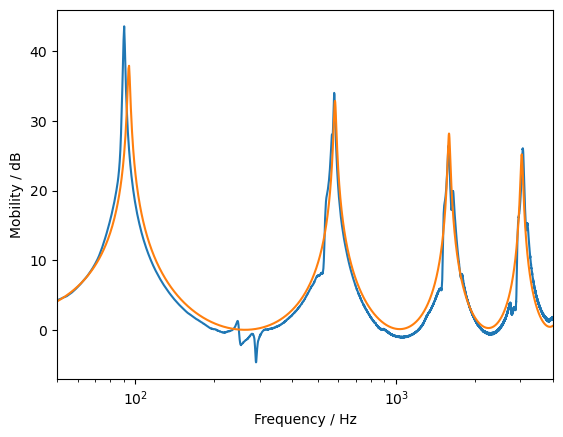

In [21]:
plt.plot(freq, 20*np.log10(tf_center))
plt.plot(np.arange(50, 4000.5, 0.5), 20*np.log10(results["vel_est"]))
plt.xscale("log")
plt.xlabel("Frequency / Hz")
plt.ylabel("Mobility / dB")
plt.xlim([50, 4000])


In [59]:
results = {"vel_est": comsolResults,
           "E_est": 3.47582687e+09,  
           "E_dist": chain[:, 0],
           "rho_est": 1332.87040193,  
           "rho_dist": chain[:, 1],
           "eta_est": 0.20146556,
           "eta_dist": chain[:, 2],
           "completedResults": mcstat.simulation_results.results,
           "error": error}

['E', 'rho', 'eta']


Text(0.1, 175, 'Estimated Eta: 0.19853324')

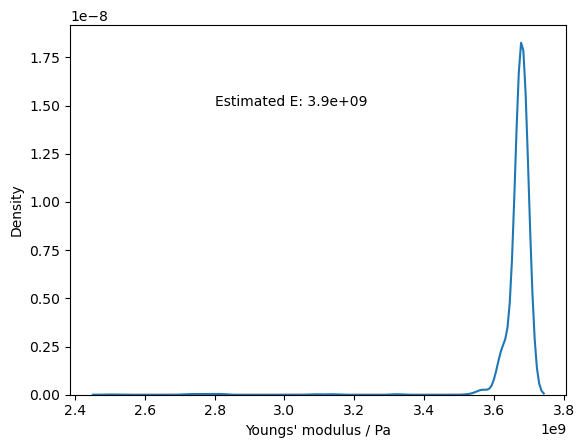

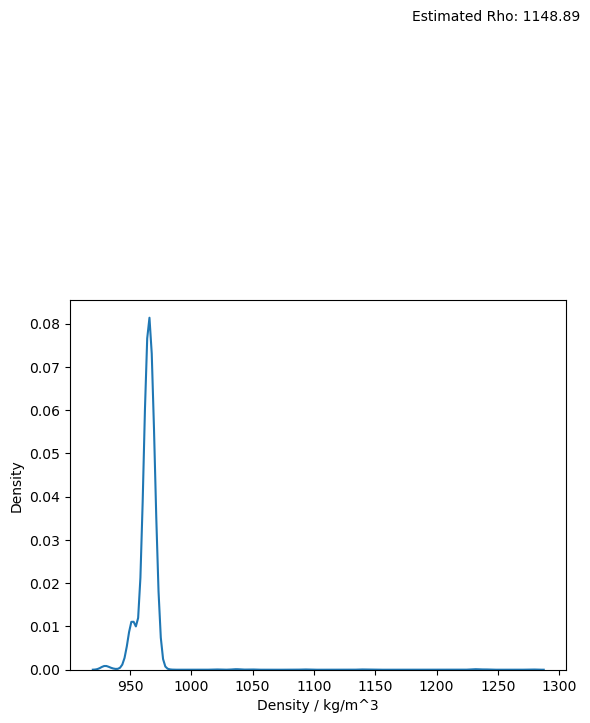

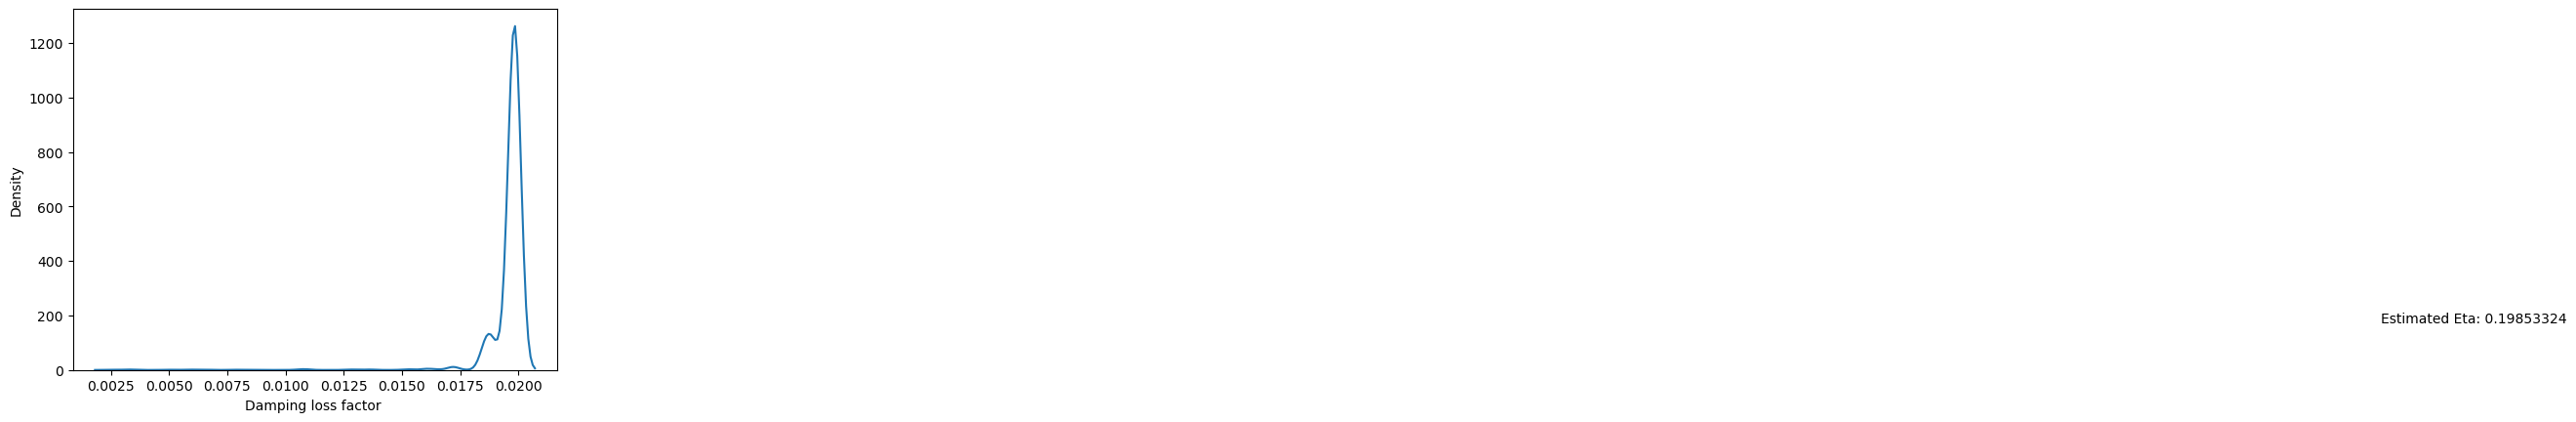

In [22]:
import seaborn as sns
plt.figure(1)
sns.kdeplot(chain[:,0])
plt.xlabel("Youngs' modulus / Pa")
plt.text(x=2.8e9, y=1.5e-8,s="Estimated E: 3.9e+09")
plt.figure(2)
sns.kdeplot(chain[:,1])
plt.xlabel("Density / kg/m^3")
plt.text(x=1180, y=0.15,s="Estimated Rho: 1148.89")
plt.figure(3)
sns.kdeplot(chain[:,2])
plt.xlabel("Damping loss factor ")
plt.text(x=0.1, y=175,s="Estimated Eta: 0.19853324")